# Quantify Outliers Across Cancer Subtypes

Given an arbitrary p-value cutoff of 0.05, quantify up-regulated expression outliers across 10 tumor subtypes for ~1,000 TCGA samples when GTEx is used as the background comparison set.

In [131]:
import pandas as pd
import numpy as np
import os
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.20)
sns.set_style("whitegrid")


class Outliers:
    def __init__(self, sample_dir, sample_path):
        self.sample_dir = sample_dir
        self.sample_path = sample_path
        self.df = self._load_df(sample_path)
        self.tissue = self.df.tissue
        self.subtype = self.df.subtype
        self.pval_df = self._pval_df()

    def _pval_df(self) -> pd.DataFrame:
        pvals = []
        for sample_name in os.listdir(self.sample_dir):
            # Check if matched tissue was used in the weight
            w_path = os.path.join(self.sample_dir, sample_name, "weights.tsv")
            w = pd.read_csv(w_path, sep="\t", index_col=0)
            tissue = self.tissue.loc[sample_name]
            if not tissue in w.index:
                continue
            #if 'Minor' in w.index:
            #    if w.loc['Minor'].Median > 0.15:
            #        continue
            pval_path = os.path.join(self.sample_dir, sample_name, "pvals.tsv")
            p = pd.read_csv(pval_path, sep="\t")
            p["sample"] = sample_name
            p["tissue"] = self.tissue.loc[sample_name]
            p["subtype"] = self.subtype.loc[sample_name]
            pvals.append(p)
        pvals = pd.concat(pvals)
        return pvals.sort_values("tissue").reset_index(drop=True)

    @staticmethod
    def _load_df(path):
        """Loads DataFrame"""
        print(f"Reading in {path}")
        if path.endswith(".csv"):
            df = pd.read_csv(path, index_col=0)
        elif path.endswith(".tsv"):
            df = pd.read_csv(path, sep="\t", index_col=0)
        else:
            try:
                df = pd.read_hdf(path)
            except Exception as e:
                print(e)
                raise RuntimeError(f"Failed to open DataFrame: {path}")
        return df


In [132]:
drug_path = '/mnt/data/outlier/drug-genes.txt'
drug_genes = sorted([x.strip() for x in open(drug_path).readlines()])

## Outlier Counts

In [133]:
o = Outliers(
    sample_dir='/mnt/normsd-outlier-runs/gtex-1000/',
    sample_path='/mnt/data/outlier/tumor.hd5'
)

Reading in /mnt/data/outlier/tumor.hd5


In [134]:
pdf = o.pval_df
pdf = pdf[pdf.Pval <= 0.05]
pdf = pdf[pdf.Gene.isin(drug_genes)]

In [135]:
counts = pdf.groupby('tissue')['Gene'].value_counts().reset_index(name='count')

Text(0.5, 0, 'Number of outliers')

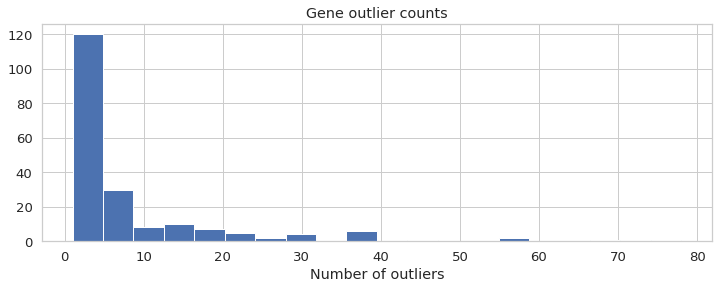

In [136]:
plt.figure(figsize=(12, 4))
plt.hist(counts['count'], bins=20)
plt.title('Gene outlier counts')
plt.xlabel('Number of outliers')

## Heatmap of Common Outlier Genes

In [137]:
counts.columns = ['Tissue', 'Gene', 'Counts']
counts.head()

,Tissue,Gene,Counts
0,Adrenal,KIT,25
1,Adrenal,CCNE1,23
2,Adrenal,MET,17
3,Adrenal,AURKA,12
4,Adrenal,CCND1,6


In [138]:
heatmap = counts.pivot(index='Gene', columns='Tissue', values='Counts')

First plot with genes with counts > 10

In [139]:
heatmap = heatmap[heatmap.sum(axis=1) > 10]

In [140]:
i = len(heatmap.index)//2
genes1 = heatmap.index[:i]
genes2 = heatmap.index[i:]

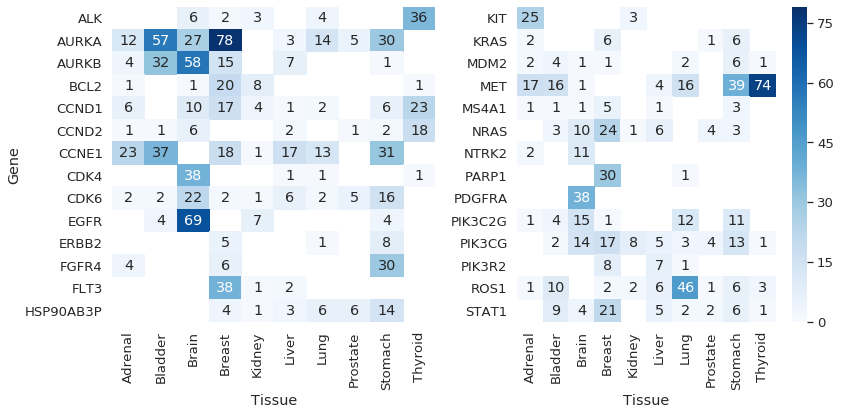

In [141]:
f, ax = plt.subplots(1, 2, sharex=True, figsize=(12, 6))
for i, genes in enumerate([genes1, genes2]):
    sub = heatmap[heatmap.index.isin(genes)]
    sns.heatmap(sub, ax=ax[i], cbar=i==1, cmap='Blues', vmin=0, vmax=79, annot=True)
ax[1].set_ylabel(None)
plt.tight_layout()
out ='/mnt/figures/outlier-counts/outliers-talk.png'
plt.savefig(out, dpi=300, transparent=True)

In [143]:
o.pval_df[(o.pval_df.Gene == 'ROS1') & (o.pval_df.tissue == 'Lung')]['sample'].value_counts().sum()

92

### Complete heatmap with all Treehouse genes

In [57]:
heatmap = counts.pivot(index='Gene', columns='Tissue', values='Counts')

In [41]:
i = len(heatmap.index)//2
genes1 = heatmap.index[:i]
genes2 = heatmap.index[i:]

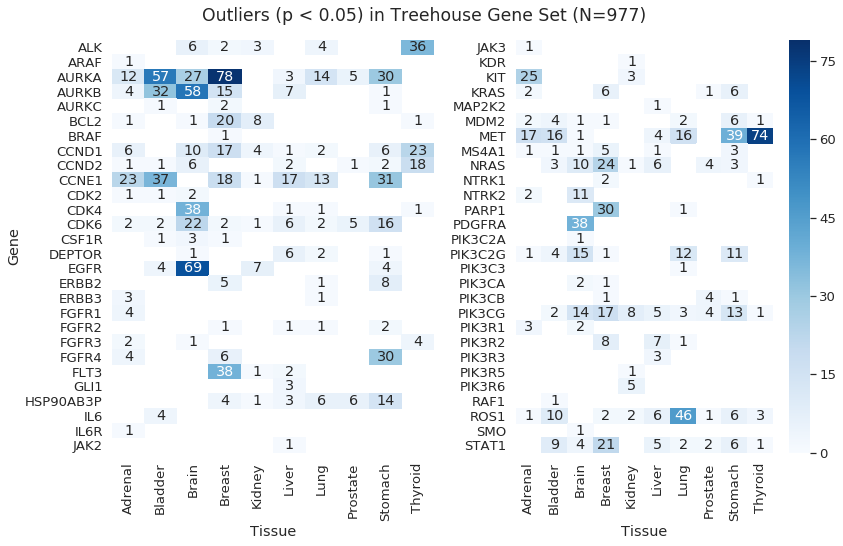

In [42]:
f, ax = plt.subplots(1, 2, sharex=True, figsize=(12, 8))
for i, genes in enumerate([genes1, genes2]):
    sub = heatmap[heatmap.index.isin(genes)]
    sns.heatmap(sub, ax=ax[i], cbar=i==1, cmap='Blues', vmin=0, vmax=79, annot=True)
ax[1].set_ylabel(None)
plt.suptitle('Outliers (p < 0.05) in Treehouse Gene Set (N=977)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
out ='/mnt/figures/outlier-counts/outliers-talk-all.png'
plt.savefig(out, dpi=300, transparent=True)